## Descriptions:

Process height and weight
- Check H&W from flowsheet first. 
- Combined with H&W from demographics for processing. 
- They are in different units!
- Check for potential erroneous recorded measurements


**Inputs**:  
- `cohort_demo` contains demographics and ESI
- `flowsheetHW` contains queried HW from flowsheet

**Outputs**: 
* `cohort_HW` contains both demographics and H&W

### Importing R libraries

In [6]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
# library(mice)

options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

Warning message:
"package 'bigrquery' was built under R version 4.0.5"


### Set up and run queries

In [7]:
# CREDENTIALS depending on LOCATIONS:
# credential <- paste0("/home/", "minh084", "/.config/gcloud/application_default_credentials.json")

# local computer
credential <- "C:/Users/User/AppData/Roaming/gcloud/application_default_credentials.json"

# Nero onprem
# credential <- "/home/minh084/.config/gcloud/application_default_credentials.json"

# Nero gcp notebook
# credential <- "/home/jupyter/.config/gcloud/application_default_credentials.json"

project_id <- "som-nero-phi-jonc101"

Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = credential)
Sys.setenv(GCLOUD_PROJECT = project_id)
gargle::credentials_app_default()

NULL

In [3]:
library(DBI)
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "shc_core" #, billing = project_id
)
con 
dbListTables(con)

<BigQueryConnection>
  Dataset: som-nero-phi-jonc101.shc_core
  Billing: som-nero-phi-jonc101

[1] "adt"                 "allergy"             "culture_sensitivity"
 [4] "demographic"         "dep_map"             "diagnosis_code"     
 [7] "drg_code"            "encounter"           "family_hx"          
[10] "flowsheet"           "lab_result"          "lda"                
[13] "mapped_meds"         "mar"                 "med_orderset"       
[16] "ndc_code"            "order_med"           "order_proc"         
[19] "order_quest"         "proc_note"           "proc_orderset"      
[22] "procedure_code"      "prov_map"            "social_hx"          
[25] "treatment_team"

### Use Flowsheet to get Height and Weight
- Height in inches and Weight in oz in flowsheet vs. cm and kg in demographics
    - Height(cm) = Height(inches) * 2.54 (in_2_cm)
    - Weight(kg) = Weight(oz) * 0.02835 (oz_2_kg)
- H&W in demographics are recent values, could be the latest from flowsheet, but not necessarily
- Explore H&W first, extract valid values for H&W from flowsheet
- Replace by NA invalid H&W from demographics.
- Merge them back together


In [9]:
# read inputs
datadir = "../../DataTD"
featuredir = "../../OutputTD/2_features"


cohort_demo <- read.csv(file.path(featuredir, "cohort_demo.csv"))
hw <- read.csv(file.path(datadir, "HWflowsheet.csv")) %>% 
        select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, row_disp_name,
               recorded_time = recorded_time_utc, num_value1, num_value2) 

# check for unique CSNs and MRNs
nrow(cohort_demo) #45796
nrow(hw) #depending on which cohort_demo used to query flowsheet 218930

nrow(cohort_demo %>% select(anon_id) %>% distinct()) #31513
nrow(hw %>% select(anon_id) %>% distinct())  #30152

nrow(cohort_demo %>% select(pat_enc_csn_id_coded) %>% distinct()) #45796
nrow(hw %>% select(pat_enc_csn_id_coded) %>% distinct()) #43609

# note that distinct CSNs are also distinct (MRNs and CSNs)
nrow(cohort_demo %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #45796
nrow(hw %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #43609

# cohort_demo %>% summarise(n_patients = n_distinct(anon_id))
# check num_value1 and num_value2
hw %>% group_by(row_disp_name) %>% count(sort=TRUE)

colnames(cohort_demo)
colnames(hw)

[1] 45796

[1] 218930

[1] 31513

[1] 30152

[1] 45796

[1] 43609

[1] 45796

[1] 43609

row_disp_name,n
<chr>,<int>
Weight,174944
Height,43986


[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "recent_height_cm"        "recent_weight_kg"       
[11] "insurance"               "recent_date"            
[13] "age"                     "English"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "row_disp_name"          
[5] "recorded_time"           "num_value1"             
[7] "num_value2"

In [10]:
# there's nothing in num_value2 for Height and Weight under flowsheet
# hw %>% group_by(row_disp_name, units) %>% summarise(count1 = length(num_value1), count2 = num_value2) %>% distinct()

hw %>% group_by(row_disp_name) %>% 
        summarise(n1 = length(num_value1[!is.na(num_value1)]), n2=length(num_value2[!is.na(num_value2)]))

summary(hw %>% select(num_value1, num_value2))

`summarise()` ungrouping output (override with `.groups` argument)



row_disp_name,n1,n2
<chr>,<int>,<int>
Height,43521,0
Weight,171832,0


   num_value1       num_value2    
 Min.   :    2.33   Mode:logical  
 1st Qu.: 1714.30   NA's:218930   
 Median : 2384.50                 
 Mean   : 2203.52                 
 3rd Qu.: 2987.20                 
 Max.   :22046.00                 
 NA's   :3577                     

In [11]:
# first, let's remove the num_value2 as nothing is in there
hw <- hw %>% select(-num_value2) %>% distinct()

# grab all duplicates columns with different num_value1 as these interferes with spread
hw[duplicated(hw[,1:5]) | duplicated(hw[,1:5], fromLast=TRUE), ] %>% 
    arrange(anon_id, pat_enc_csn_id_coded, recorded_time) 
# group_by(hw, colnames) %>% filter(n() > 1)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,row_disp_name,recorded_time,num_value1
<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
JC2a092e0,131283843655,46362760,Weight,2020-03-31 07:00:00+00:00,3006.40
JC2a092e0,131283843655,46362760,Weight,2020-03-31 07:00:00+00:00,3001.78
JC2a22262,131287061282,47545247,Weight,2020-03-31 07:00:00+00:00,2816.00
JC2a22262,131287061282,47545247,Weight,2020-03-31 07:00:00+00:00,3216.95
JCd245f1,131287460729,47793743,Weight,2020-03-31 07:00:00+00:00,2651.20
JCd245f1,131287460729,47793743,Weight,2020-03-31 07:00:00+00:00,2730.18
JCe6cf4d,131284198681,46589021,Weight,2020-03-31 07:00:00+00:00,3495.61
JCe6cf4d,131284198681,46589021,Weight,2020-03-31 07:00:00+00:00,3462.40
JCe7239c,131284737083,46855910,Weight,2020-03-31 07:00:00+00:00,3681.60


In [12]:
# let's take the average of these values because they are very similar.
# Otherwise, if there are errors, remove them first. Spread to Height and Weight columns
hw <- hw %>% group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, row_disp_name, recorded_time) %>%
            summarize(num_value1 = mean(num_value1, na.rm=TRUE)) %>% spread(row_disp_name, num_value1)
nrow(hw) #185645
colnames(hw)

`summarise()` regrouping output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'row_disp_name' (override with `.groups` argument)



[1] 185645

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "recorded_time"          
[5] "Height"                  "Weight"

### Height and Weight
- Height in inches and Weight in oz in flowsheet vs. cm and kg in demographics
    - Height(cm) = Height(inches) * 2.54 (in_2_cm)
    - Weight(kg) = Weight(oz) * 0.02835 (oz_2_kg) 

- Aim to use flowsheet H&W as the source, closest time to admit time. 
    - Height: compare values within patients
    - Weight: compare values within encounters
- For missing H&W values, get replacements from demographics' H&W

In [13]:
# Height (fs vs. demo)
# recent_height_cm is likely the latest flowsheet height, all patients appear in flowsheet
hidfs <- hw %>% filter(!is.na(Height)) %>% distinct(pat_enc_csn_id_coded)
hiddm <- cohort_demo %>% filter(!is.na(recent_height_cm)) %>% distinct(pat_enc_csn_id_coded)

nrow(hidfs) #33608
nrow(hiddm) #44383

# we only care about the ids in cohort_demo, should be a subset of ids in flowsheet
length(hiddm$pat_enc_csn_id_coded %in% hidfs$pat_enc_csn_id_coded) #44383

[1] 33608

[1] 44383

[1] 44383

In [14]:
# Weight (fs vs. demo)
# recent_weight_kg is likely the latest flowsheet height, all patients appear in flowsheet
widfs <- hw %>% filter(!is.na(Weight)) %>% distinct(pat_enc_csn_id_coded)
widdm <- cohort_demo %>% filter(!is.na(recent_weight_kg)) %>% distinct(pat_enc_csn_id_coded)

nrow(widfs)
nrow(widdm)
length(widdm$pat_enc_csn_id_coded %in% widfs$pat_enc_csn_id_coded)

[1] 43213

[1] 45486

[1] 45486

In [ ]:
# nrow(left_join(cohort_demo, hw)) - nrow(left_join(cohort_demo, hw) %>% filter(is.na(Height), is.na(Weight))) #187832

In [15]:
# calculate time difference, by the minutes and days
# calculate difference in H&W of flowsheet and demographics, cm & kg
in_2_cm = 2.54
oz_2_kg = 0.02835

hw1 <- left_join(cohort_demo, hw) %>%  
                mutate(adredif = abs(as.numeric(difftime(admit_time, recorded_time, units = 'mins'))),
                       dmfsdif = as.numeric(difftime(date(ymd(recent_date)), date(ymd_hms(recorded_time)), units = 'days')),
                       Hfsdmdif = abs(round(Height*2.54,2) - recent_height_cm),
                       Wfsdmdif = abs(round(Weight*0.02835,2) - recent_weight_kg)) #%>%
#                 group_by(anon_id, pat_enc_csn_id_coded) %>%
#                 filter(mindiff == min(mindiff)) %>% slice(1L) %>%
#                 filter_at(vars(Weight, Height), any_vars(!is.na(.))) # remove any rows that have both NA in H&W

# drop rows that have NA in both (Height and Weight)
# if there's NA, when widening the df, will have a NA col                
nrow(hw1) #187832

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded")



[1] 187832

In [16]:
# many weights recorded, some are errorenous
# check encounters with only 1 H&W vs. more than 1
# looks for Weight information within same encounter (e) # (and possibly same patient (p))

suppressWarnings(
hw1 <- hw1 %>% group_by(anon_id, pat_enc_csn_id_coded) %>% 
                mutate(nWe = length(Weight[!is.na(Weight)]),
                       minWe = min(Weight, na.rm=TRUE), maxWe = max(Weight, na.rm=TRUE),
                       rmaxWe = round(maxWe/Weight, 2)) #%>%
    
# nHe = length(Height[!is.na(Height)]),
# minHe = min(Height, na.rm=TRUE), maxHe = max(Height, na.rm=TRUE),
# rmaxHe = round(maxHe/Height, 2),
    
#                 group_by(anon_id) %>% 
#                 mutate(nWp = length(Weight[!is.na(Weight)]), nHp = length(Height[!is.na(Height)]),
#                        minW = min(Weight, na.rm=TRUE), maxW = max(Weight, na.rm=TRUE),
#                        rmaxWp = round(maxW/Weight, 2)) #%>% select(-'<NA>')
)

### Explore Height (from flowsheet, in inches): 
- Consider errors if Height < 45in (~ 114m) or > 90in (~2.2m)
- For the rest, get Height from flowsheet that is closest to Height from demographics, per patient, regardless of encounters

[1] 90

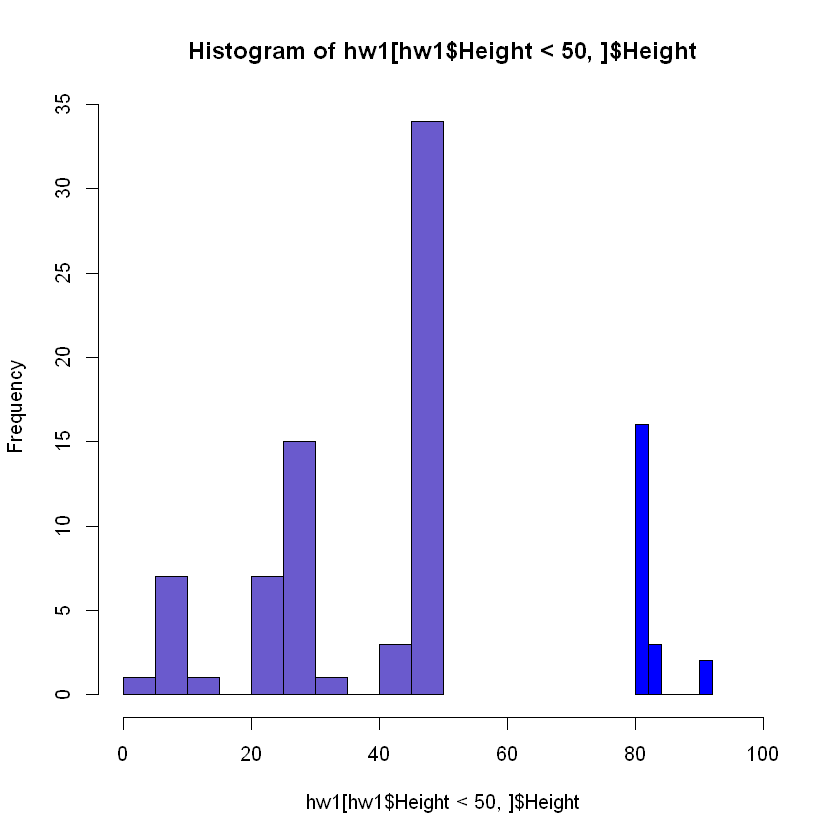

In [17]:
hist(hw1[hw1$Height < 50,]$Height, xlim=c(0, 100), col="slateblue") # remove < 40 (keep 42)
hist(hw1[hw1$Height > 80,]$Height, col="blue", add=TRUE) # remove > 85 or 90

errorH <- hw1 %>% filter(Height < 50 | Height > 80) %>% arrange(Height)
nrow(errorH)

In [18]:
# strict cut at 45 and 90
errorH %>% select(anon_id, pat_enc_csn_id_coded, recent_date, recent_weight_kg, recent_height_cm, 
                  admit_time, recorded_time, Height)
dim(errorH)
colnames(errorH)

anon_id,pat_enc_csn_id_coded,recent_date,recent_weight_kg,recent_height_cm,admit_time,recorded_time,Height
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
JCce2775,131178284907,2019-01-01,48.20,152.40,2016-01-29 01:54:00,2016-01-29 19:27:00+00:00,4.800
JCd6b805,131064542495,2019-01-01,71.80,12.95,2015-01-04 10:50:00,2015-01-04 12:00:00+00:00,5.100
JCdc2922,131265024354,2019-09-05,67.00,162.56,2019-04-16 22:28:00,2019-04-17 01:04:00+00:00,5.400
JCe1c1fc,131265023495,2020-03-31,107.50,157.48,2019-04-10 20:39:00,2019-04-11 00:35:00+00:00,5.400
JCe0abb0,131265179321,2019-09-17,75.30,14.48,2019-03-26 13:37:00,2019-03-28 19:12:00+00:00,5.700
JCcc3bf6,131186309411,2020-03-31,107.90,185.40,2016-04-29 19:23:00,2016-04-29 20:16:00+00:00,6.000
JCe40481,131090941774,2020-03-31,78.02,182.88,2015-06-29 06:27:00,2015-06-29 06:31:00+00:00,6.000
JCe42654,131197301808,2019-01-01,77.40,182.90,2016-09-05 05:18:00,2016-09-05 07:01:00+00:00,6.000
JCe48557,131224927517,2020-03-31,81.65,170.20,2017-05-11 00:59:00,2017-05-11 04:00:00+00:00,14.488


[1] 90 25

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "recent_height_cm"        "recent_weight_kg"       
[11] "insurance"               "recent_date"            
[13] "age"                     "English"                
[15] "recorded_time"           "Height"                 
[17] "Weight"                  "adredif"                
[19] "dmfsdif"                 "Hfsdmdif"               
[21] "Wfsdmdif"                "nWe"                    
[23] "minWe"                   "maxWe"                  
[25] "rmaxWe"

#### Process Height from flowsheet, to merge with cohort_demo again later
- input `hw1`, output `h` = only all valid Heights available from flowsheet
- there are many recent_heights in  `cohort_demo` but not in flowsheet
- there are a few with valid Height in flowsheet with no valid recent_height in demographics (only care about CSNs in cohort_demo)

In [19]:
length(unique(cohort_demo$anon_id)) #31513
length(unique(hw1$anon_id)) #31513

# remove the most erroneous values and NAs under flowsheet
# take the closest values of flowsheet's Heights to Heights in demographics, per patients
h <- hw1 %>% filter(!is.na(Height), Height >= 45, Height <= 90) %>% group_by(anon_id) %>% slice(which.min(Hfsdmdif))
# group_by(anon_id) %>% slice_min(order_by = Hfsdmdif)

nrow(h) #24324
length(unique(h$anon_id)) #24324
length(unique(h$pat_enc_csn_id_coded)) #24324

# those without H&W from demo
colSums(is.na(h[, c('Hfsdmdif', 'Wfsdmdif')]))

[1] 31513

[1] 31513

[1] 24324

[1] 24324

[1] 24324

Hfsdmdif Wfsdmdif 
       0     5577

In [20]:
# after processing, check for possible errors in a narrower range [45, 50) or (80, 90]
h %>% filter(Height < 50 | Height > 80) %>% arrange(Hfsdmdif, Height) %>%
        select(anon_id, pat_enc_csn_id_coded, recent_date, recent_weight_kg, recent_height_cm, 
               admit_time, recorded_time, Height, Hfsdmdif)

anon_id,pat_enc_csn_id_coded,recent_date,recent_weight_kg,recent_height_cm,admit_time,recorded_time,Height,Hfsdmdif
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
JCe0ac93,131283990134,2020-03-31,63.00,115.00,2020-03-08 06:38:00,2020-03-09 02:19:00+00:00,45.276,0.00
JCe57462,131072762363,2020-03-31,40.82,120.00,2015-02-27 09:20:00,2015-02-27 10:03:00+00:00,47.244,0.00
JCdd3957,131228153200,2019-01-01,66.50,121.00,2017-04-21 01:12:00,2017-04-25 07:05:00+00:00,47.638,0.00
JCd60f63,131071931233,2019-01-01,70.00,121.92,2015-01-22 23:54:00,2015-01-22 11:00:00+00:00,48.000,0.00
JCe445c6,131128132055,2020-03-08,54.88,121.92,2015-10-08 01:55:00,2015-10-07 21:52:00+00:00,48.000,0.00
JC2a04f84,131285883834,2020-03-31,97.80,203.84,2020-03-22 23:59:00,2020-03-23 16:00:00+00:00,80.250,0.00
JCd6b400,131264041990,2020-03-31,162.70,205.74,2019-01-29 05:09:00,2019-01-28 23:41:00+00:00,81.000,0.00
JCe1f81a,131171351962,2020-01-22,124.87,208.28,2015-12-25 02:28:00,2015-12-25 03:51:00+00:00,82.000,0.00
JCe7857e,131073935110,2020-02-26,173.55,208.28,2015-02-03 22:38:00,2015-02-05 03:54:00+00:00,82.000,0.00


In [21]:
# these Heights look most suspicious, can take averages, or respect the flowsheet records
checkH <- c('JCe79d23', 'JCcd8dd0', 'JCd00624', 'JCde3ccf')
hw1 %>% filter(anon_id %in% checkH, !is.na(Height)) %>%
         select(anon_id, pat_enc_csn_id_coded, age, recent_date, recent_weight_kg, recent_height_cm, 
                admit_time, recorded_time, Height, Hfsdmdif) %>% arrange(Hfsdmdif)

anon_id,pat_enc_csn_id_coded,age,recent_date,recent_weight_kg,recent_height_cm,admit_time,recorded_time,Height,Hfsdmdif
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
JCcd8dd0,131084068642,85,2020-03-31,66.68,139.70,2015-03-29 04:36:00,2015-03-29 04:42:00+00:00,49.20,14.73
JCde3ccf,131259368765,71,2020-02-22,76.60,149.00,2018-10-06 04:20:00,2018-10-06 07:55:00+00:00,49.32,23.73
JCd00624,131073317688,80,2019-01-01,52.40,149.86,2015-03-03 03:22:00,2015-03-03 03:40:00+00:00,49.32,24.59
JCe79d23,131075033012,76,2020-03-28,65.30,149.20,2015-03-16 14:17:00,2015-03-16 14:35:00+00:00,49.00,24.74


In [22]:
# Height in flowsheets seem to be too low, take demographics' Height
nrow(h) #24324
h <- h %>% filter(!anon_id %in% checkH)
nrow(h) #24320

[1] 24324

[1] 24320

In [23]:
# remove invalid height in demo, compare counts, will not use this 
h_recent <- cohort_demo %>% filter(!is.na(recent_height_cm), recent_height_cm >=45*in_2_cm, recent_height_cm <=90*in_2_cm) 
length(unique(h_recent$anon_id)) #30139
length(unique(h$anon_id)) #24320

# patients with h from flowsheet but no valid recent_height
anti_join(h, h_recent, by=c("anon_id"))

# patients NO h from flowsheet but valid recent_height
nrow(anti_join(h_recent, h, by=c("anon_id")))

[1] 30139

[1] 24320

anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,recent_height_cm,recent_weight_kg,insurance,recent_date,age,English,recorded_time,Height,Weight,adredif,dmfsdif,Hfsdmdif,Wfsdmdif,nWe,minWe,maxWe,rmaxWe
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
JCdf7023,131267775047,0,2019-06-08 00:19:00,36910146,3,Female,White,111.60,55.0,0,2020-03-31,54,1,2019-06-07 21:00:00+00:00,67,2127.00,1440,298,58.58,5.3,1,2127.00,2127.00,1.00
JCe0abb0,131265179321,1,2019-03-26 13:37:00,35185661,2,Male,Asian,14.48,75.3,1,2019-09-17,63,1,2019-03-26 15:00:00+00:00,67,2663.16,0,175,155.70,0.2,4,2596.14,2811.31,1.06


[1] 6270

In [24]:
# 12 patients within invalid recent_heights, many NAs, 
cohort_demo %>% filter(recent_height_cm < 45*in_2_cm | recent_height_cm > 90*in_2_cm) 

# this one has recent_height of 111cm, but Height = 67in = 170cm
hw1 %>% filter(anon_id == 'JCdf7023')

anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,recent_height_cm,recent_weight_kg,insurance,recent_date,age,English
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>
JC2a2d702,131267052804,0,2019-05-15 01:14:00,36434138,3,Female,Other,65.00,82.80,0,2020-03-31,76,0
JCd2d4eb,131236770818,0,2017-08-12 11:21:00,25544867,3,Male,White,68.00,102.06,0,2019-01-01,80,1
JCd6b805,131064542495,0,2015-01-04 10:50:00,13858638,2,Female,Other,12.95,71.80,0,2019-01-01,20,1
JCd8d241,131236791940,0,2017-08-06 23:17:00,25553574,3,Male,Asian,66.00,64.50,1,2019-08-13,80,1
JCd8d241,131273357211,0,2019-08-08 08:32:00,39794104,3,Male,Asian,66.00,64.50,1,2019-08-13,82,1
JCdf7023,131222744464,0,2017-04-15 05:05:00,23851365,3,Female,White,111.60,55.00,0,2020-03-31,52,1
JCdf7023,131242758905,0,2018-01-16 00:24:00,27798938,3,Female,White,111.60,55.00,0,2020-03-31,52,1
JCdf7023,131267775047,0,2019-06-08 00:19:00,36910146,3,Female,White,111.60,55.00,0,2020-03-31,54,1
JCe0abb0,131265179321,1,2019-03-26 13:37:00,35185661,2,Male,Asian,14.48,75.30,1,2019-09-17,63,1


anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,recent_height_cm,recent_weight_kg,insurance,recent_date,age,English,recorded_time,Height,Weight,adredif,dmfsdif,Hfsdmdif,Wfsdmdif,nWe,minWe,maxWe,rmaxWe
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
JCdf7023,131222744464,0,2017-04-15 05:05:00,23851365,3,Female,White,111.6,55,0,2020-03-31,52,1,2017-04-15 01:32:00+00:00,NA,1957.68,0,1081,NA,0.5,1,1957.68,1957.68,1
JCdf7023,131242758905,0,2018-01-16 00:24:00,27798938,3,Female,White,111.6,55,0,2020-03-31,52,1,2018-01-16 01:20:00+00:00,NA,2172.85,0,805,NA,6.6,1,2172.85,2172.85,1
JCdf7023,131267775047,0,2019-06-08 00:19:00,36910146,3,Female,White,111.6,55,0,2020-03-31,54,1,2019-06-07 21:00:00+00:00,67,2127.00,1440,298,58.58,5.3,1,2127.00,2127.00,1


### Explore Weight (from flowsheet, in ounces): 
- Consider errors and remove first
    - Weight > 12000 (12345.9 oz = 350kg) 
    - Weight < 720 (45lbs or 20.4kg)
- For the remaining Weights
    - see details under process Weight

In [25]:
summary(hw1$Weight) # 22046.00 is 625kg, 710 is about 20kg, 900 is about 25.5kg

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
    2.33  2166.40  2603.19  2744.79  3153.46 22046.00    16008 

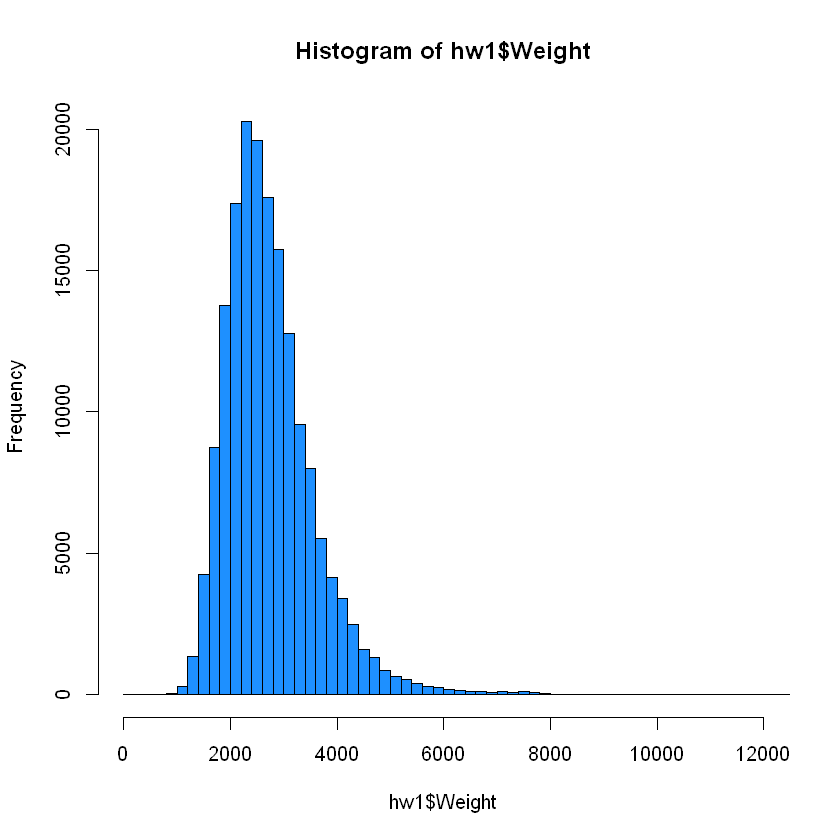

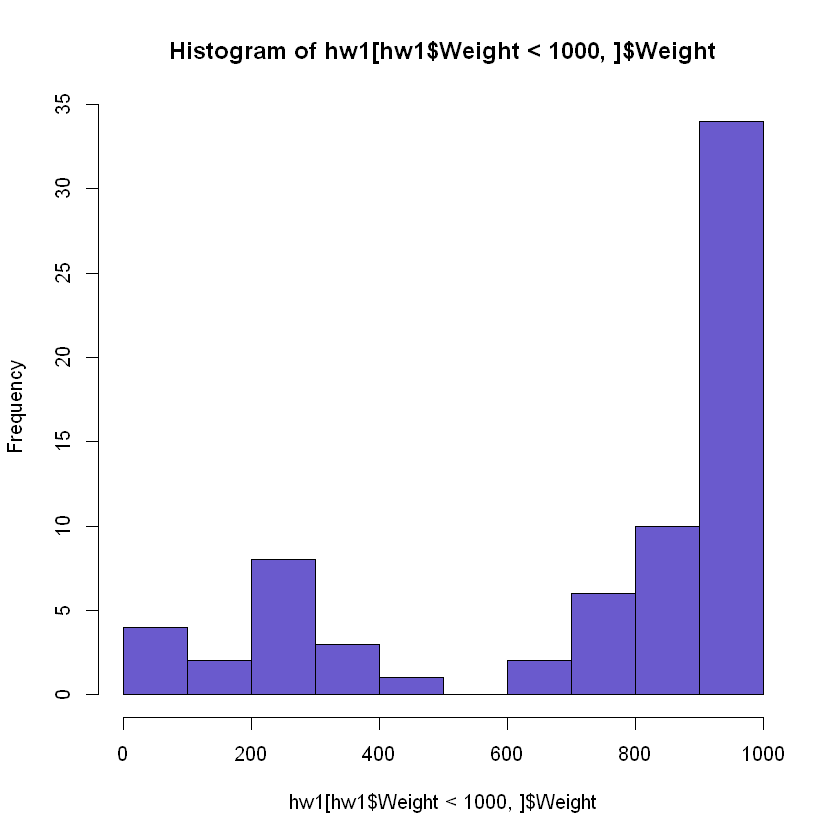

[1] 172

[1] 66

[1] 84

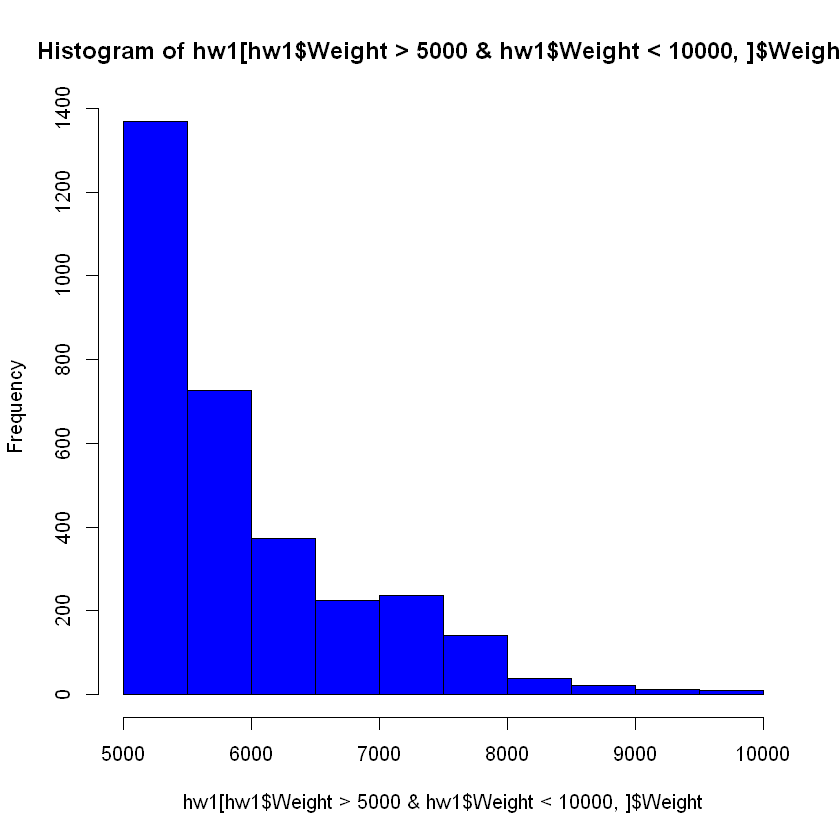

In [26]:
hist(hw1$Weight, breaks=100, xlim=c(0, 12000), col="dodgerblue")
hist(hw1[hw1$Weight < 1000,]$Weight, xlim=c(0,1000), col="slateblue") 
hist(hw1[hw1$Weight > 5000 & hw1$Weight < 10000,]$Weight, col="blue") 

# possible errors in Weight
errorW <- hw1 %>% filter(Weight < 1000 | Weight > 8000) %>% arrange(Weight)
nrow(errorW)

length(unique(errorW$anon_id))
length(unique(errorW$pat_enc_csn_id_coded))

In [27]:
errorW %>% select(anon_id, pat_enc_csn_id_coded, age, recent_date, recent_height_cm, recent_weight_kg, 
                  admit_time, recorded_time, Weight, Wfsdmdif, dmfsdif) %>% arrange(Weight)

anon_id,pat_enc_csn_id_coded,age,recent_date,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,Wfsdmdif,dmfsdif
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
JCd8c850,131083429185,77,2019-01-01,162.56,61.23,2015-03-29 20:11:00,2015-03-29 23:28:00+00:00,2.33,61.16,1374
JCdb8af3,131179908315,58,2019-01-01,170.20,0.10,2016-02-02 21:38:00,2016-02-08 15:28:00+00:00,3.45,0.00,1058
JCd4d996,131276336621,72,2019-11-29,175.26,97.60,2019-09-21 04:25:00,2019-09-21 12:17:00+00:00,17.64,97.10,69
JCcfa790,131279920409,87,2020-01-15,182.91,82.10,2019-11-11 23:44:00,2019-11-12 01:30:00+00:00,28.23,81.30,64
JCdd701d,131216269634,58,2019-01-01,160.02,47.94,2017-02-21 20:25:00,2017-02-23 04:12:00+00:00,172.80,43.04,677
JCccaf6f,131148206526,76,2019-01-01,160.02,51.70,2015-12-28 05:49:00,2015-12-28 06:45:00+00:00,192.00,46.26,1100
JCe7f41e,131278541034,64,2020-02-27,165.00,62.10,2019-10-12 23:06:00,2019-10-18 20:14:00+00:00,204.59,56.30,132
JCe3e7e8,131197934631,61,2019-01-01,182.90,70.00,2016-08-16 22:25:00,2016-08-16 22:07:00+00:00,208.00,64.10,868
JC2a01205,131261419878,24,2020-03-31,NA,68.00,2019-01-18 13:56:00,2019-01-18 07:57:00+00:00,215.17,61.90,438


In [28]:
# patients appear more than once in the errorW: 
# from the above cell and here: errors are < 720 and > 13000
# all look ok, except errors: 12381.03oz and 12024.77 
# (and possible errors # JCe36b60 9600.00 & 9770.79, but this is 1 special case, not big deal --> handle later)
# final: remove < 720 and > 12000
dup_errorW <- errorW[duplicated(errorW[,'anon_id']) | duplicated(errorW[,'anon_id'], fromLast=TRUE), ] %>% 
                    select(anon_id, pat_enc_csn_id_coded, age, recent_date, recent_height_cm, recent_weight_kg, 
                           admit_time, recorded_time, Weight, nWe) %>% arrange(anon_id, recorded_time)

length(unique(dup_errorW$anon_id))
dup_errorW

[1] 28

anon_id,pat_enc_csn_id_coded,age,recent_date,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,nWe
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
JC2a02d79,131267473325,37,2020-03-31,175.26,211.00,2019-06-05 11:41:00,2019-06-06 00:32:00+00:00,8359.84,16
JC2a02d79,131267473325,37,2020-03-31,175.26,211.00,2019-06-05 11:41:00,2019-06-06 12:45:00+00:00,8317.51,16
JC2a23e61,131268863704,67,2020-02-24,124.50,38.56,2019-06-17 05:31:00,2019-06-18 23:30:00+00:00,804.24,5
JC2a23e61,131268863704,67,2020-02-24,124.50,38.56,2019-06-17 05:31:00,2019-06-19 23:02:00+00:00,888.89,5
JC2a23e61,131268863704,67,2020-02-24,124.50,38.56,2019-06-17 05:31:00,2019-06-20 17:03:00+00:00,853.62,5
JCcb9b40,131172519842,39,2019-01-01,182.88,260.50,2016-01-07 10:19:00,2016-01-08 08:13:00+00:00,9241.68,4
JCcb9b40,131172519842,39,2019-01-01,182.88,260.50,2016-01-07 10:19:00,2016-01-08 16:27:00+00:00,8486.83,4
JCcb9b40,131172519842,39,2019-01-01,182.88,260.50,2016-01-07 10:19:00,2016-01-09 16:29:00+00:00,8977.13,4
JCcba5a7,131139556413,86,2019-01-01,152.00,27.00,2015-10-31 00:41:00,2015-10-30 19:27:00+00:00,848.01,5


In [29]:
# these patients appeared once in errorW, so likely all errors 
# verify in the next cell, check for possible correct values (<1000 or >8000)
non_dup_errorW <- errorW %>% filter(!anon_id %in% dup_errorW$anon_id) %>%
                                select(anon_id, pat_enc_csn_id_coded, age, recent_date, recent_height_cm, recent_weight_kg, 
                                       admit_time, recorded_time, Weight, nWe, Wfsdmdif, dmfsdif) %>% arrange(Weight) 

length(unique(non_dup_errorW$anon_id))
non_dup_errorW

[1] 38

anon_id,pat_enc_csn_id_coded,age,recent_date,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,nWe,Wfsdmdif,dmfsdif
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
JCd8c850,131083429185,77,2019-01-01,162.56,61.23,2015-03-29 20:11:00,2015-03-29 23:28:00+00:00,2.33,2,61.16,1374
JCdb8af3,131179908315,58,2019-01-01,170.20,0.10,2016-02-02 21:38:00,2016-02-08 15:28:00+00:00,3.45,4,0.00,1058
JCd4d996,131276336621,72,2019-11-29,175.26,97.60,2019-09-21 04:25:00,2019-09-21 12:17:00+00:00,17.64,2,97.10,69
JCcfa790,131279920409,87,2020-01-15,182.91,82.10,2019-11-11 23:44:00,2019-11-12 01:30:00+00:00,28.23,2,81.30,64
JCdd701d,131216269634,58,2019-01-01,160.02,47.94,2017-02-21 20:25:00,2017-02-23 04:12:00+00:00,172.80,4,43.04,677
JCccaf6f,131148206526,76,2019-01-01,160.02,51.70,2015-12-28 05:49:00,2015-12-28 06:45:00+00:00,192.00,4,46.26,1100
JCe7f41e,131278541034,64,2020-02-27,165.00,62.10,2019-10-12 23:06:00,2019-10-18 20:14:00+00:00,204.59,9,56.30,132
JCe3e7e8,131197934631,61,2019-01-01,182.90,70.00,2016-08-16 22:25:00,2016-08-16 22:07:00+00:00,208.00,2,64.10,868
JC2a01205,131261419878,24,2020-03-31,NA,68.00,2019-01-18 13:56:00,2019-01-18 07:57:00+00:00,215.17,3,61.90,438


In [30]:
# verify the above are errors! 
# look for possible valid values that are < 1000 or  > 8000 --> ok to remove all except JCd0500f of 987.66 might be valid
eW2 <- non_dup_errorW %>% filter(Weight > 720, Weight < 12000) # within (720, 1000) & (8000, 12000)
hw1 %>% filter(anon_id %in% eW2$anon_id, !is.na(Weight)) %>% 
        select(anon_id, pat_enc_csn_id_coded, age, recent_date, recent_height_cm, recent_weight_kg, 
               admit_time, recorded_time, Weight, nWe) %>% arrange(anon_id, recorded_time)

anon_id,pat_enc_csn_id_coded,age,recent_date,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,nWe
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
JC2a0784f,131072025806,33,2020-03-05,167.64,232.10,2015-01-21 21:24:00,2015-01-21 04:27:00+00:00,6816.00,3
JC2a0784f,131072025806,33,2020-03-05,167.64,232.10,2015-01-21 21:24:00,2015-01-22 22:30:00+00:00,7647.32,3
JC2a0784f,131072025806,33,2020-03-05,167.64,232.10,2015-01-21 21:24:00,2015-01-23 22:12:00+00:00,7562.66,3
JC2a0784f,131242882845,36,2020-03-05,167.64,232.10,2017-12-12 14:17:00,2017-12-12 06:37:00+00:00,8640.00,2
JC2a0784f,131242882845,36,2020-03-05,167.64,232.10,2017-12-12 14:17:00,2017-12-12 11:53:00+00:00,7368.66,2
JCcbb4b8,131075411816,44,2019-01-01,165.10,57.90,2015-02-17 06:42:00,2015-02-17 23:09:00+00:00,1869.50,4
JCcbb4b8,131075411816,44,2019-01-01,165.10,57.90,2015-02-17 06:42:00,2015-02-18 15:49:00+00:00,1862.45,4
JCcbb4b8,131075411816,44,2019-01-01,165.10,57.90,2015-02-17 06:42:00,2015-02-19 16:57:00+00:00,1841.28,4
JCcbb4b8,131075411816,44,2019-01-01,165.10,57.90,2015-02-17 06:42:00,2015-02-20 16:45:00+00:00,1798.95,4


In [32]:
hw1 %>% filter(anon_id %in% c('JCd0500f'), !is.na(Weight)) %>% 
        select(anon_id, pat_enc_csn_id_coded, age, recent_date, recent_height_cm, recent_weight_kg, 
               admit_time, recorded_time, Weight, nWe, Wfsdmdif, dmfsdif) %>% arrange(anon_id, recorded_time)

anon_id,pat_enc_csn_id_coded,age,recent_date,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,nWe,Wfsdmdif,dmfsdif
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
JCd0500f,131186131047,66,2020-03-31,165.1,123.2,2016-05-22 07:10:00,2016-05-22 07:43:00+00:00,987.66,1,95.2,1409
JCd0500f,131277983176,69,2020-03-31,165.1,123.2,2019-11-01 06:18:00,2019-11-01 01:53:00+00:00,4190.50,1,4.4,151


#### Process Weight
input `hw1`, output `w`
- remove <720 and >12000
- remove those with only 1 value in (<1000 and >8000) but have other values in [1000, 80000]
- more difficult with Weights within 1000 and 8000 but have large differences:
    - take the average of other weights of the same encounters but not the exact value at evaluation, *X(-i)* or *avg_Xself*
    - get ratio different of self/average not self, *r_avg_Xself*
    - if one value, take it (*avg_Xself* = NaN) --> `w1`
    - if 2 values, take average (*r_avg_Xself* = 1) --> `w2`
    - if 3 or more: get the first 3 closest to admit_time, then pick the one with *r_avg_Xself* closest to 1 --> `w3`

In [33]:
length(unique(cohort_demo$pat_enc_csn_id_coded)) #45796
length(unique(hw1$pat_enc_csn_id_coded)) #45796

# remove erroneous values and NAs first, retain only patients with possible valid Weight under flowsheet
w <- hw1 %>% filter(Weight >= 720, Weight <= 12000, !is.na(Weight)) %>% anti_join(eW2)

length(unique(w$pat_enc_csn_id_coded)) #43211
colnames(w)

[1] 45796

[1] 45796

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "recent_height_cm", "recent_weight_kg", "recent_date", "age", "recorded_time", "Weight", "dmfsdif", "Wfsdmdif", "nWe")



[1] 43211

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "recent_height_cm"        "recent_weight_kg"       
[11] "insurance"               "recent_date"            
[13] "age"                     "English"                
[15] "recorded_time"           "Height"                 
[17] "Weight"                  "adredif"                
[19] "dmfsdif"                 "Hfsdmdif"               
[21] "Wfsdmdif"                "nWe"                    
[23] "minWe"                   "maxWe"                  
[25] "rmaxWe"

In [34]:
# within the same patients, same encounters:
# recalculate count/max/ratio of W to max W/ratio of W over average not self Weight... 
w <- w %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, age, recent_weight_kg, 
                  recent_date, admit_time, recorded_time, Weight, Wfsdmdif) %>% 
            group_by(anon_id, pat_enc_csn_id_coded) %>% 
            mutate(nWe =length(Weight[!is.na(Weight)]), maxWe = max(Weight, na.rm=TRUE), rmaxWe = round(maxWe/Weight, 2), 
                   avg_Xself= round((sum(Weight)-Weight)/(nWe-1),2),
                   r_avg_Xself= round(Weight/avg_Xself, 2)) %>%
#             mutate(d_avg_Xself = ifelse(is.na(d_avg_Xself), 1, d_avg_Xself)) %>%
            arrange(anon_id, pat_enc_csn_id_coded, r_avg_Xself)
summary(w)

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:171784      Min.   :1.311e+11    Min.   :13616753       
 Class :character   1st Qu.:1.312e+11    1st Qu.:20243087       
 Mode  :character   Median :1.312e+11    Median :27729787       
                    Mean   :1.312e+11    Mean   :28207502       
                    3rd Qu.:1.313e+11    3rd Qu.:34458262       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
      age        recent_weight_kg recent_date         admit_time       
 Min.   :18.00   Min.   :  0.10   Length:171784      Length:171784     
 1st Qu.:46.00   1st Qu.: 60.65   Class :character   Class :character  
 Median :61.00   Median : 73.10   Mode  :character   Mode  :character  
 Mean   :58.49   Mean   : 76.91                                        
 3rd Qu.:72.00   3rd Qu.: 88.45                                        
 Max.   :90.00   Max.   :320.69                 

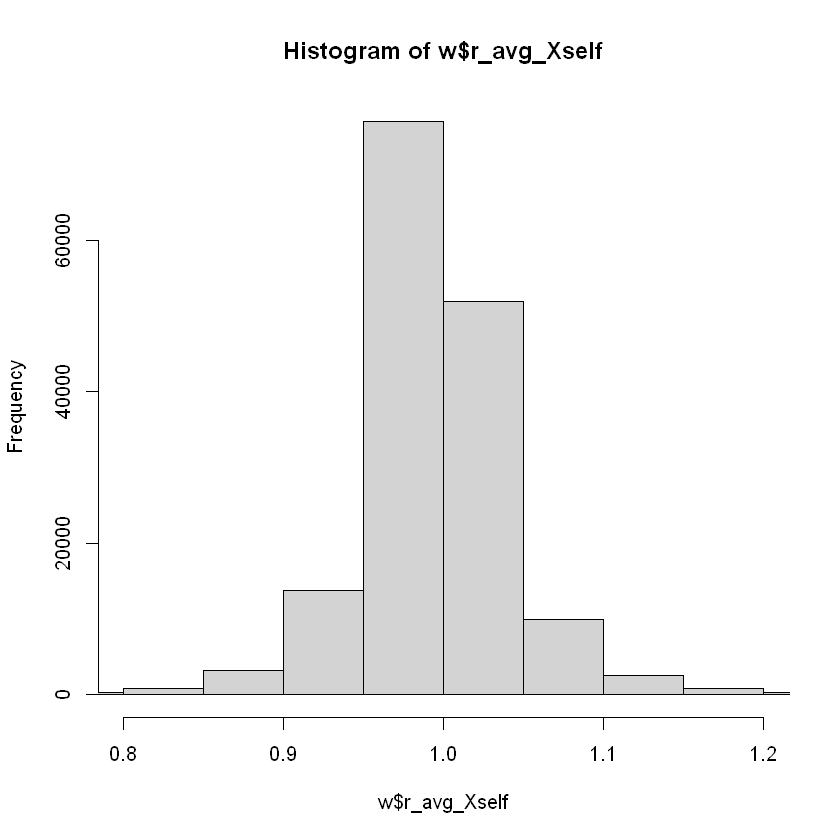

In [35]:
hist(w$r_avg_Xself, xlim=c(0.8, 1.2), breaks=100)

In [36]:
# extract Weights depending on scenarios of how many available Weights per encounters
w1 <- w %>% filter(nWe == 1)
w2 <- w %>% filter(nWe == 2) %>% group_by(anon_id, pat_enc_csn_id_coded) %>% mutate(Weight = mean(Weight)) %>% # no NA here
        arrange(anon_id, pat_enc_csn_id_coded, Weight) %>% slice(1L) # take one if both are the same
w3 <- w %>% filter(nWe > 2) %>% arrange(anon_id, pat_enc_csn_id_coded, recorded_time) %>% slice(1:3) %>%
        mutate(d1 = abs(r_avg_Xself-1)) %>% # difference of r_avg_Xself to 1, from either sides
        arrange(anon_id, pat_enc_csn_id_coded, d1) %>% slice(1L) # take the first closest to 1

nrow(w1) #12004
length(unique(w1$pat_enc_csn_id_coded))
nrow(w2) #9897
nrow(w %>% filter(nWe == 2) %>% distinct(pat_enc_csn_id_coded))
nrow(w3) #21310
nrow(w %>% filter(nWe > 2) %>% distinct(pat_enc_csn_id_coded))

[1] 12004

[1] 12004

[1] 9897

[1] 9897

[1] 21310

[1] 21310

In [37]:
nrow(w1) + nrow(w2) + nrow(w3) #43211
combinedW <- full_join(w1, w2) %>% full_join (w3)
nrow(combinedW)
length(unique(combinedW$pat_enc_csn_id_coded))

[1] 43211

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "age", "recent_weight_kg", "recent_date", "admit_time", "recorded_time", "Weight", "Wfsdmdif", "nWe", "maxWe", "rmaxWe", "avg_Xself", "r_avg_Xself")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "age", "recent_weight_kg", "recent_date", "admit_time", "recorded_time", "Weight", "Wfsdmdif", "nWe", "maxWe", "rmaxWe", "avg_Xself", "r_avg_Xself")



[1] 43211

[1] 43211

In [38]:
# sanity check, this patient has 2 first possible erroneous values
w %>% filter(anon_id =='JCdcc100', pat_enc_csn_id_coded== 131265384824) %>% group_by(pat_enc_csn_id_coded) %>% 
        select(Weight, nWe, recorded_time, admit_time, avg_Xself, r_avg_Xself) %>% arrange(recorded_time)
combinedW %>% filter(anon_id =='JCdcc100', pat_enc_csn_id_coded== 131265384824) %>% group_by(pat_enc_csn_id_coded) %>% 
        select(Weight, nWe, recorded_time, admit_time, avg_Xself, r_avg_Xself) %>% arrange(recorded_time)

Adding missing grouping variables: `pat_enc_csn_id_coded`



pat_enc_csn_id_coded,Weight,nWe,recorded_time,admit_time,avg_Xself,r_avg_Xself
<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
131265384824,2028.23,7,2019-04-02 00:48:00+00:00,2019-04-02 03:47:00,2893.32,0.70
131265384824,2051.20,7,2019-04-02 06:45:00+00:00,2019-04-02 03:47:00,2889.49,0.71
131265384824,3082.91,7,2019-04-06 17:14:00+00:00,2019-04-02 03:47:00,2717.54,1.13
131265384824,3033.53,7,2019-04-10 14:46:00+00:00,2019-04-02 03:47:00,2725.77,1.11
131265384824,2998.26,7,2019-04-11 17:44:00+00:00,2019-04-02 03:47:00,2731.65,1.10
131265384824,3121.71,7,2019-04-16 10:59:00+00:00,2019-04-02 03:47:00,2711.08,1.15
131265384824,3072.33,7,2019-04-17 10:55:00+00:00,2019-04-02 03:47:00,2719.31,1.13


Adding missing grouping variables: `pat_enc_csn_id_coded`



pat_enc_csn_id_coded,Weight,nWe,recorded_time,admit_time,avg_Xself,r_avg_Xself
<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
131265384824,3082.91,7,2019-04-06 17:14:00+00:00,2019-04-02 03:47:00,2717.54,1.13


In [39]:
# remove invalid weight in demo, compare counts, will not use this for merging as it remove patients from the cohort_demo
# no invalid recent_weight, only NA
w_recent <- cohort_demo %>% filter(recent_weight_kg >= 720*oz_2_kg, recent_weight_kg <= 12000*oz_2_kg, !is.na(recent_weight_kg))

length(unique(w_recent$pat_enc_csn_id_coded)) #45482
length(unique(combinedW$pat_enc_csn_id_coded)) #43211

# patients with w from flowsheet but no valid recent_weight
nrow(anti_join(combinedW, w_recent, by=c("pat_enc_csn_id_coded"))) #46

# patients NO w from flowsheet but valid recent_weight
nrow(anti_join(w_recent, combinedW, by=c("pat_enc_csn_id_coded"))) #2317

[1] 45482

[1] 43211

[1] 46

[1] 2317

### Combine Height and Weight with demogrpahic table
- Weight in kg and Height in cm
- Combine valid H&W dataframes from flowsheet
- Merge with original cohort_demo to make sure we have all cohort
- Replace errorneous values in cohort_demo as NA
    - Height < 45 * in_2_cm & >  90 * in_2_cm --> NA
    - Weight < 720 * oz_2_kg & > 12000 * oz_2_kg --> NA
- If no H&W in flowsheet, use the one from demographics (recent H&W)

In [40]:
# patients NO h from flowsheet but valid recent_height
nrow(anti_join(h_recent, h, by=c("anon_id"))) #6270
length(unique(h_recent$anon_id)) #30139
colnames(h)

# patients NO w from flowsheet but valid recent_weight
nrow(anti_join(w_recent, combinedW, by=c("anon_id"))) #1342
length(unique(w_recent$pat_enc_csn_id_coded)) #45482
colnames(combinedW)

[1] 6270

[1] 30139

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "recent_height_cm"        "recent_weight_kg"       
[11] "insurance"               "recent_date"            
[13] "age"                     "English"                
[15] "recorded_time"           "Height"                 
[17] "Weight"                  "adredif"                
[19] "dmfsdif"                 "Hfsdmdif"               
[21] "Wfsdmdif"                "nWe"                    
[23] "minWe"                   "maxWe"                  
[25] "rmaxWe"

[1] 1342

[1] 45482

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "age"                    
 [5] "recent_weight_kg"        "recent_date"            
 [7] "admit_time"              "recorded_time"          
 [9] "Weight"                  "Wfsdmdif"               
[11] "nWe"                     "maxWe"                  
[13] "rmaxWe"                  "avg_Xself"              
[15] "r_avg_Xself"             "d1"

In [41]:
# combine valid H&W from flowsheet
fsH <- h %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, Height)
fsW <- combinedW %>% select(anon_id, pat_enc_csn_id_coded, Weight)

fsHW <- full_join(fsH, fsW)
nrow(fsHW) #43464
length(unique(fsHW$pat_enc_csn_id_coded)) #43464

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 43464

[1] 43464

In [57]:
# check cohort_demo, with H and W already removed erroneous values
cohort_demo <- read.csv(file.path(featuredir, "cohort_demo.csv"))
nrow(cohort_demo) #45796
length(unique(cohort_demo$anon_id)) #31513
length(unique(cohort_demo$pat_enc_csn_id_coded)) #45796

summary(cohort_demo %>% select(recent_height_cm, recent_weight_kg))

nrow(cohort_demo %>% filter(recent_height_cm < 45*in_2_cm | recent_height_cm >  90*in_2_cm)) #12
nrow(cohort_demo %>% filter(recent_weight_kg < 720*oz_2_kg | recent_weight_kg > 12000*oz_2_kg)) #4

# replace cohort_demo H&W with NA for the bad
cohort_demo <- cohort_demo %>% mutate(recent_height_cm = ifelse(recent_height_cm < 45*in_2_cm | recent_height_cm > 90*in_2_cm, 
                                                     NA, recent_height_cm),
                                      recent_weight_kg = ifelse(recent_weight_kg < 720*oz_2_kg | recent_weight_kg > 12000*oz_2_kg, 
                                                     NA, recent_weight_kg))

summary(cohort_demo %>% select(recent_height_cm, recent_weight_kg))

# patients in flowsheet but no matching in demographics: all fs are in cohort_demo
nrow(anti_join(fsHW, cohort_demo, by=c("anon_id", "pat_enc_csn_id_coded"))) #0
colnames(fsHW)
colnames(cohort_demo)

[1] 45796

[1] 31513

[1] 45796

 recent_height_cm recent_weight_kg
 Min.   : 12.95   Min.   :  0.1   
 1st Qu.:160.02   1st Qu.: 60.9   
 Median :167.64   Median : 73.1   
 Mean   :167.97   Mean   : 76.6   
 3rd Qu.:175.26   3rd Qu.: 88.0   
 Max.   :210.82   Max.   :320.7   
 NA's   :1413     NA's   :310     

[1] 12

[1] 4

 recent_height_cm recent_weight_kg
 Min.   :115.0    Min.   : 20.5   
 1st Qu.:160.0    1st Qu.: 60.9   
 Median :167.6    Median : 73.1   
 Mean   :168.0    Mean   : 76.6   
 3rd Qu.:175.3    3rd Qu.: 88.0   
 Max.   :210.8    Max.   :320.7   
 NA's   :1425     NA's   :314     

[1] 0

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "Height"                 
[5] "Weight"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "recent_height_cm"        "recent_weight_kg"       
[11] "insurance"               "recent_date"            
[13] "age"                     "English"

In [61]:
cohort_hw <- left_join(cohort_demo, fsHW) %>% 
                group_by(anon_id, pat_enc_csn_id_coded) %>%
                mutate(Height = ifelse(is.na(Height), recent_height_cm, round(Height * in_2_cm, 0)),
                       Weight = ifelse(is.na(Weight), recent_weight_kg, round(Weight * oz_2_kg, 0))) 

nrow(cohort_hw) #45796 last
length(unique(cohort_hw$anon_id)) #31513
length(unique(cohort_hw$pat_enc_csn_id_coded)) #45796

# the distributions are pretty close. this is good. 
summary(cohort_hw %>% select(Height, Weight, recent_height_cm, recent_weight_kg))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded")



[1] 45796

[1] 31513

[1] 45796

Adding missing grouping variables: `anon_id`, `pat_enc_csn_id_coded`



   anon_id          pat_enc_csn_id_coded     Height          Weight      
 Length:45796       Min.   :1.311e+11    Min.   :115.0   Min.   : 20.50  
 Class :character   1st Qu.:1.312e+11    1st Qu.:160.0   1st Qu.: 61.00  
 Mode  :character   Median :1.312e+11    Median :168.0   Median : 73.30  
                    Mean   :1.312e+11    Mean   :168.2   Mean   : 76.92  
                    3rd Qu.:1.313e+11    3rd Qu.:175.3   3rd Qu.: 88.00  
                    Max.   :1.313e+11    Max.   :213.0   Max.   :320.69  
                                         NA's   :1423    NA's   :312     
 recent_height_cm recent_weight_kg
 Min.   :115.0    Min.   : 20.5   
 1st Qu.:160.0    1st Qu.: 60.9   
 Median :167.6    Median : 73.1   
 Mean   :168.0    Mean   : 76.6   
 3rd Qu.:175.3    3rd Qu.: 88.0   
 Max.   :210.8    Max.   :320.7   
 NA's   :1425     NA's   :314     

In [55]:
head(cohort_hw)

anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,recent_height_cm,recent_weight_kg,insurance,recent_date,age,English,Height,Weight
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>
JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,165.1,83.46,1,2020-03-31,52,1,165.0,81.0
JC29f8ad3,131278291027,0,2019-10-05 23:48:00,42992239,3,Female,Asian,NA,NA,1,2020-02-24,35,1,NA,NA
JC29f8b9c,131266787806,0,2019-05-05 01:07:00,36261582,2,Male,Unknown,NA,NA,0,2019-01-12,59,0,NA,NA
JC29f8beb,131264387263,0,2019-03-15 03:35:00,34626013,3,Female,White,154.9,65.40,1,2019-12-22,30,1,154.9,65.4
JC29f8beb,131279241689,0,2019-11-27 15:29:00,43527040,3,Female,White,154.9,65.40,1,2019-12-22,30,1,155.0,63.0
JC29f8bef,131280937356,0,2019-11-30 10:35:00,44544574,3,Female,Asian,156.0,51.70,1,2020-03-31,60,1,156.0,51.7


In [62]:
# save file, this has all processed variables from demographics and processed HW from flowsheet
cohort_hw <- cohort_hw %>% select(-recent_height_cm, -recent_weight_kg)
write.csv(cohort_hw, file.path(featuredir, "cohort_demoHW.csv"), row.names=FALSE)